## Figure Plotting 02-10-2025

In [3]:
# pip install scienceplots

In [4]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots
import jax

import os

from jax import numpy as jnp
from jax import random
from flax import linen as nn

from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

init_dir = os.getcwd()

In [5]:
# Load in data dictionary (N, Pa)
dict_name = 'model_data_dictionary_N_Pa.pkl'
data_dict = pickle.load(open(dict_name, 'rb'))
new_dict = data_dict

In [6]:
def choose_exp_train_data(test_k, k_groups, all_nr_data): #use all_nr_data for all_data
    # selecting training data
    train_us = []
    train_ys = []
    train_fs = []
    train_ws = []

    for i in jnp.arange(k):
        if i == test_k:
            continue
        group = [all_nr_data[i] for i in k_groups[i]]
        train_us = train_us + [d[0][0] for d in group] # include data from this group
        train_ys = train_ys + [d[0][1] for d in group] # include data from this group
        train_fs = train_fs + [d[1] for d in group] # include data from this group
        train_ws = train_ws + [d[2] for d in group] # include data from this group
    # now concatenate everything into a single array
    train_us = jnp.concatenate(train_us)
    train_ys = jnp.concatenate(train_ys)
    train_fs = jnp.concatenate(train_fs)
    train_ws = jnp.concatenate(train_ws)

    train_data = (train_us, train_ys), train_fs, train_ws
    return train_data

In [7]:
PSI_to_Pa = 6894.76
lbf_to_N = 4.44822

# create array that can have all data concatenated to it
all_data = jnp.zeros((0, 10))
us = jnp.zeros((0, 7))
ps = jnp.zeros((0, 1))
fs = jnp.zeros((0, 1))
ws = jnp.zeros((0, 1))

for key in data_dict.keys():    
    u = jnp.array(data_dict[key][0][0])
    p = jnp.array(data_dict[key][0][1])
    f = jnp.array(data_dict[key][1])
    w = jnp.array(data_dict[key][2])
    
    all_data = jnp.vstack([all_data, jnp.hstack([u, p, f, w])])
    us = jnp.vstack([us, u])
    ps = jnp.vstack([ps, p])
    fs = jnp.vstack([fs, f])
    ws = jnp.vstack([ws, w])
print(f'data shape: {all_data.shape}')

data shape: (188318, 10)


In [8]:
# new_name = 'model_data_dictionary_N_Pa.pkl'
# pickle.dump(new_dict, open(new_name, 'wb'))

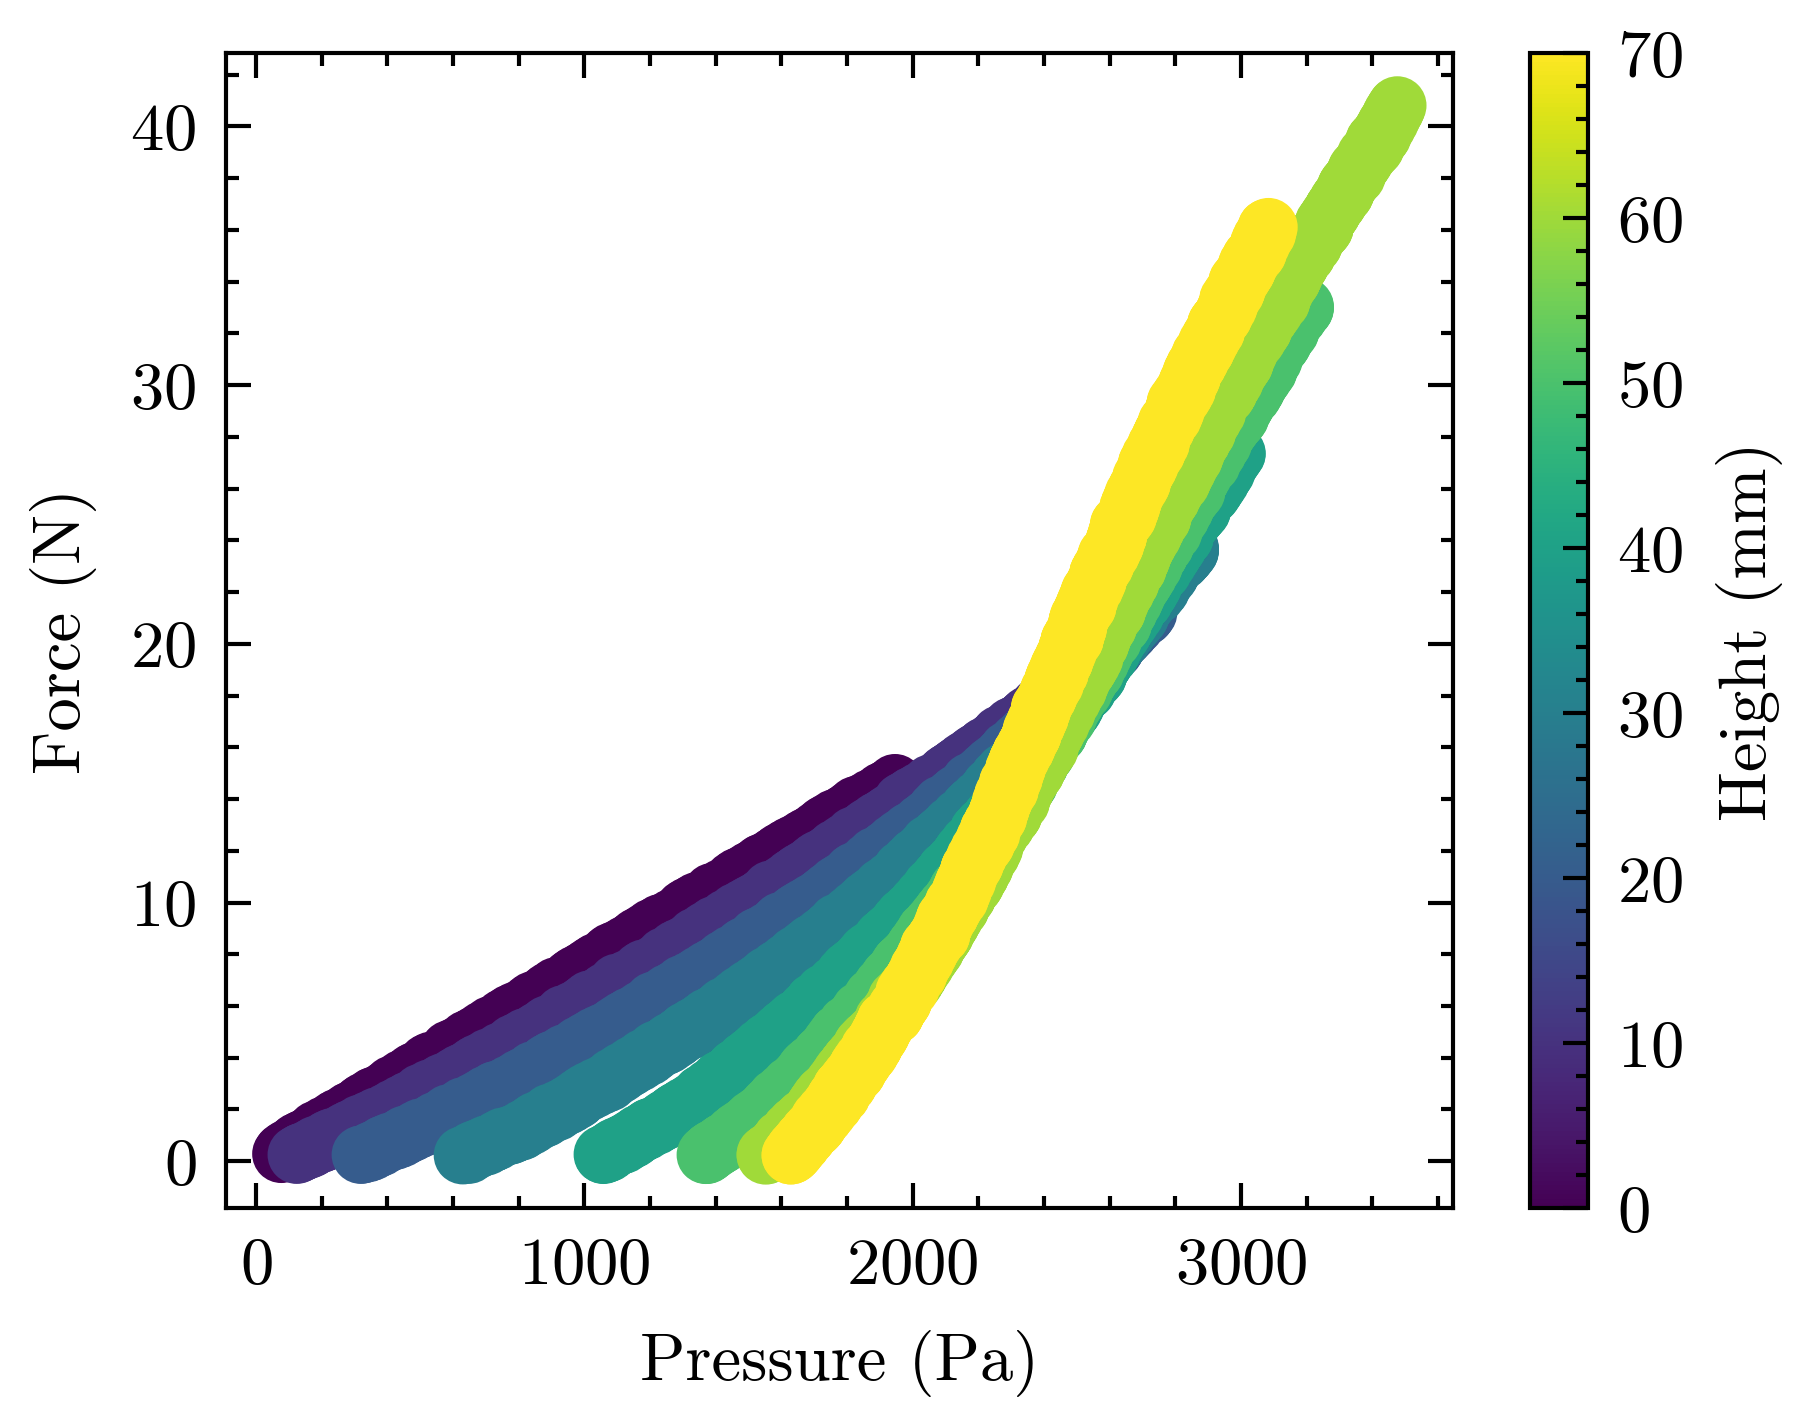

In [9]:
i = 2
key = list(new_dict.keys())[i]

with plt.style.context(['science','ieee','no-latex']):
    plt.figure()
    height = [x[0] for x in new_dict[key][0][0]]
    pressure = [x for x in new_dict[key][0][1]]
    force = [x for x in new_dict[key][1]]
    plt.scatter(pressure, force, c=height)
    bar = plt.colorbar()
    bar.set_label('Height (mm)')
    plt.xlabel('Pressure (Pa)')
    plt.ylabel('Force (N)')
    plt.show()

In [11]:
# load in TEMPORARY data
all_lift_df = pickle.load(open('TEMP_test_df.pkl', 'rb'))
In_mem = pickle.load(open('TEMP_test_mem.pkl', 'rb'))

In [12]:
# Checking how each membrane is performing for 'max height'

# Target points:
check_Fs = [[0,1,2],[1,1,1]] # use indices, as all tests are performed in same mass order (1.5kg, 1.5kg, 2.5kg, 2.5kg, 4kg, 4kg)
# first max it for all weights at 1 PSI
# check_ps = [jnp.array([1,1,1]), jnp.array([0.6,0.9,1.2])]
check_ps = [jnp.array([1,1,1]), jnp.array([0.6,0.8,1.0])]

C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\2596636261.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(lift_p, lift_h, c = color[i], marker=marks[k], label = f'{i+1, check_Fs[j][k]}')
C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\2596636261.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(lift_p, lift_h, marker=marks[k], c = color[i])


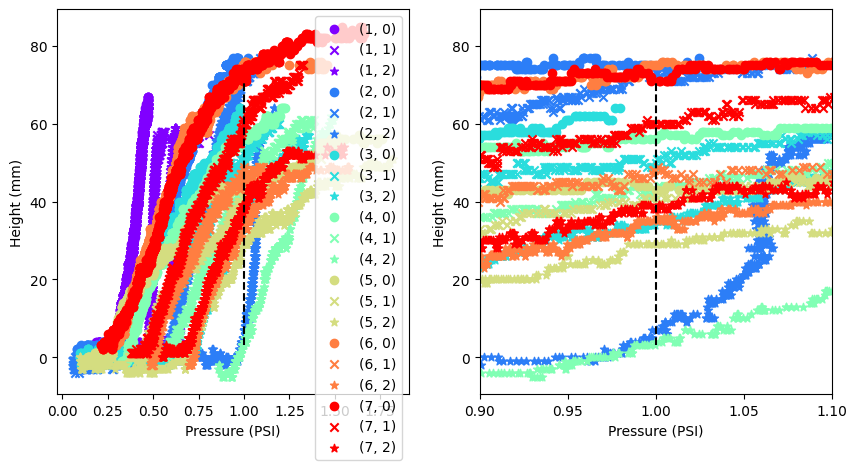

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_subplot(121), fig.add_subplot(122)]

# set up color to change by iteration
color = cm.rainbow(jnp.linspace(0, 1, len(all_lift_df)))
marks = ['o','x','*']

for i in range(len(all_lift_df)):
    # find the lifts that match check_Fs
    these_lifts = all_lift_df[i]
    j = 0 # use first set of F/p targets
    F_inds = check_Fs[j]
    for k in range(len(F_inds)):
        trial = 1 #use 'trial = 1'
        F_ind = 2*F_inds[k]+trial # based on how trials are taken, 
        this_lift = all_lift_df[i].iloc[F_ind]
        # find the point that matches p most closely
        lift_p = jnp.array(this_lift['pressure'])
        lift_h = jnp.array(this_lift['height'])
        max_height = jnp.argmax(lift_h)
        lift_h = lift_h[max_height:] - 154
        lift_p = lift_p[max_height:]
        ax[0].scatter(lift_p, lift_h, c = color[i], marker=marks[k], label = f'{i+1, check_Fs[j][k]}')
        ax[1].scatter(lift_p, lift_h, marker=marks[k], c = color[i])

# set xlim
ax[1].set_xlim([0.9, 1.1])
line_range = (jnp.array([157,225]) - 154).tolist()
ax[0].plot([check_ps[0][0],check_ps[0][0]], line_range, 'k--')
ax[1].plot([check_ps[0][0],check_ps[0][0]], line_range, 'k--')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Pressure (PSI)')
ax[0].set_ylabel('Height (mm)')
ax[1].set_xlabel('Pressure (PSI)')
ax[1].set_ylabel('Height (mm)')
plt.show()

C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\3607956292.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(lift_p, lift_h, c = color[i], label = f'Membrane {i+1}')


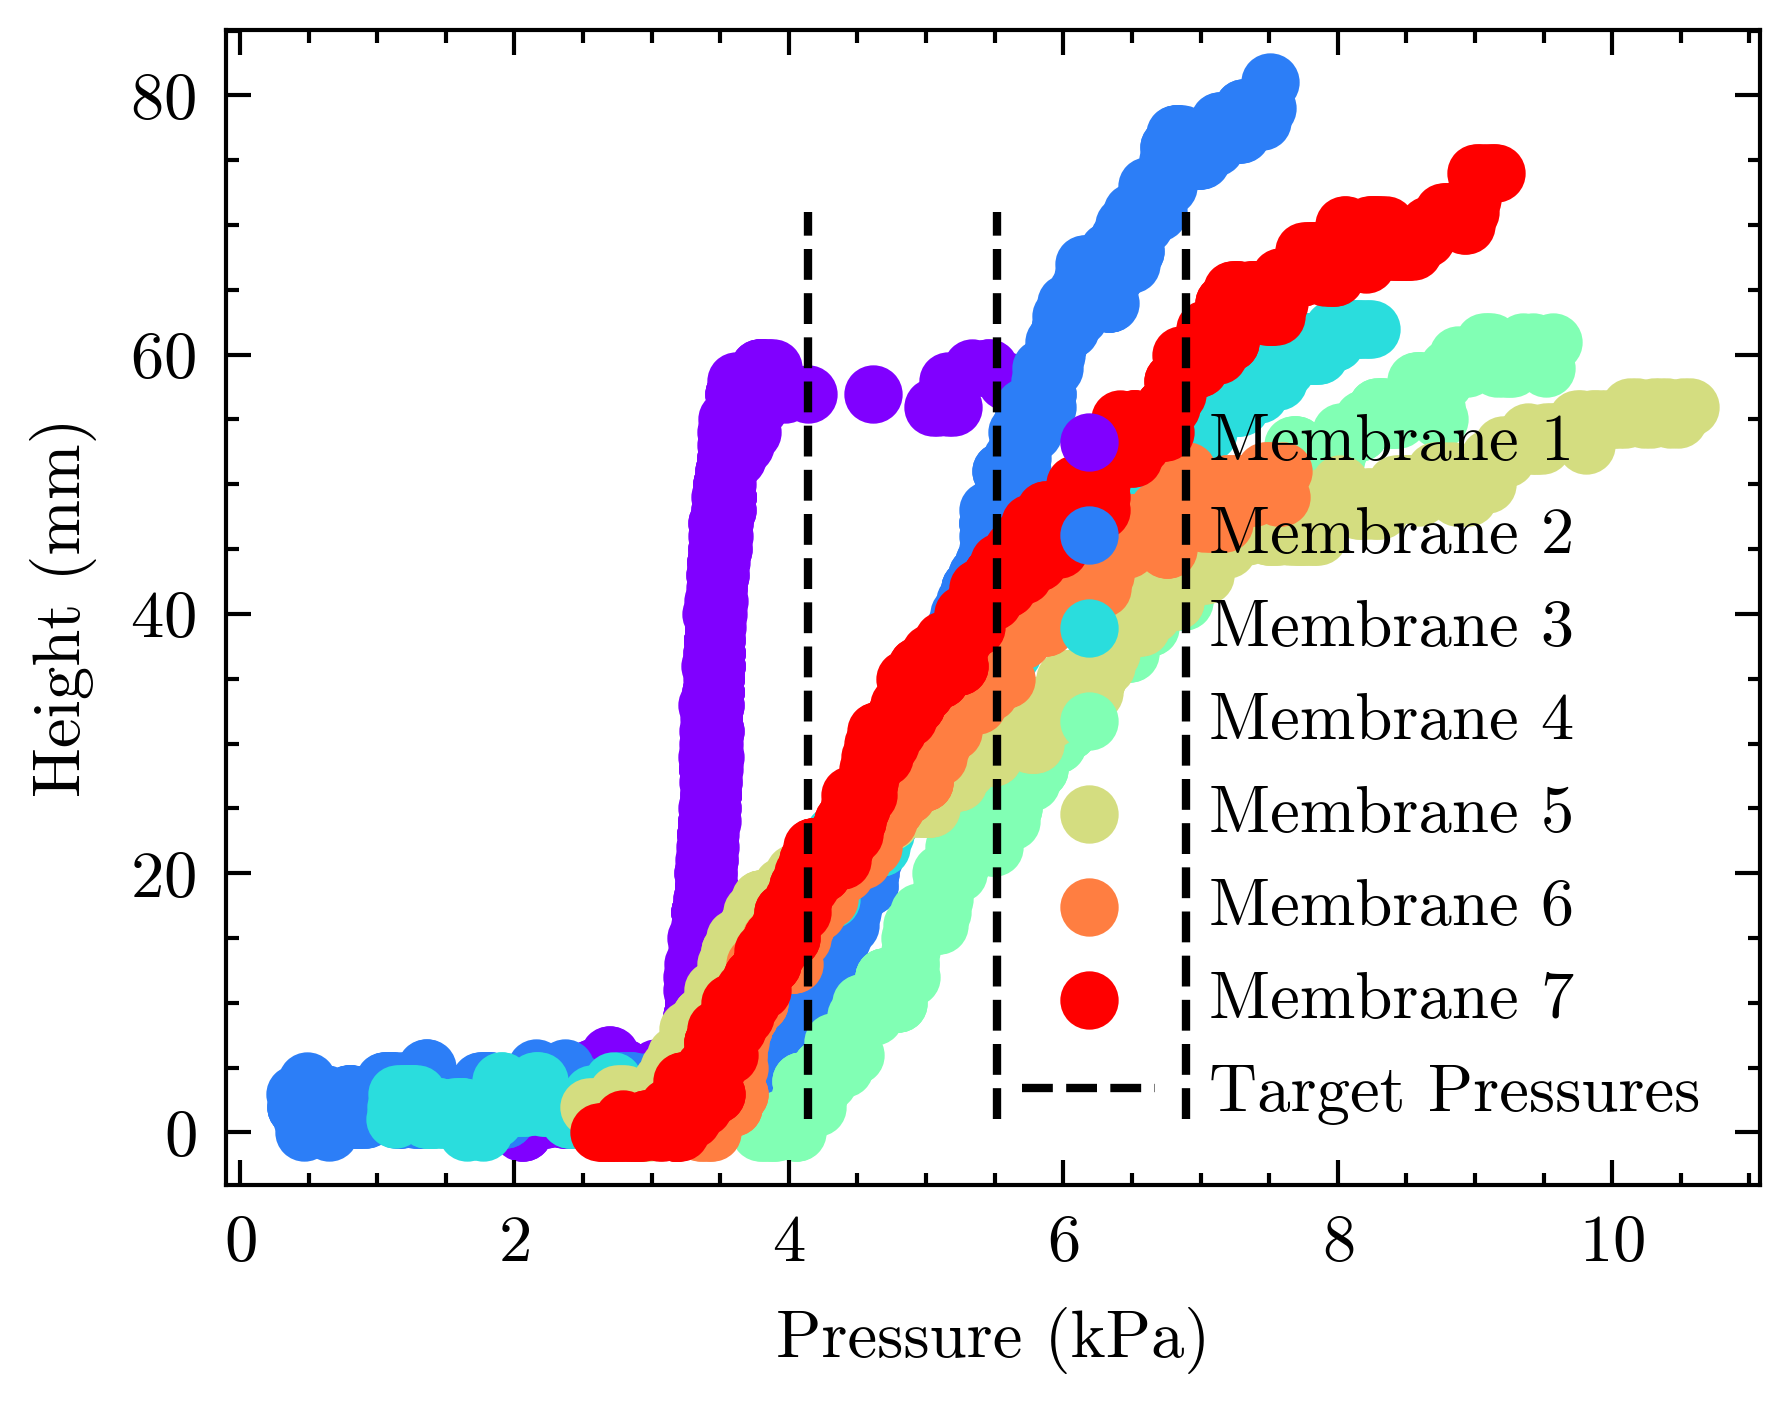

In [14]:


# set up color to change by iteration
color = cm.rainbow(jnp.linspace(0, 1, len(all_lift_df)))
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    for i in range(len(all_lift_df)):
        # find the lifts that match check_Fs
        these_lifts = all_lift_df[i]
        # for each check_F:
        j = 1 # use second set of F/p targets
        F_inds = check_Fs[j]
        # for k in range(len(F_inds)):
        k = 0
        trial = 1 #use 'trial = 1'
        F_ind = 2*F_inds[k]+trial # based on how trials are taken
        this_lift = all_lift_df[i].iloc[F_ind]
        # find the point that matches p most closely
        lift_p = jnp.array(this_lift['pressure'])*PSI_to_Pa/1000
        lift_h = jnp.array(this_lift['height'])
        max_height = jnp.argmax(lift_h)
        # lift_h = lift_h[max_height:]- 154
        lift_h = lift_h[max_height:] - min(lift_h[max_height:])
        lift_p = lift_p[max_height:]
        # plt.scatter(lift_p, lift_h, c = color[i], label = f'{i, check_Fs[j][k]}')
        plt.scatter(lift_p, lift_h, c = color[i], label = f'Membrane {i+1}')

    line_range = (jnp.array([155,225]) - 154).tolist()

    plt.plot(jnp.array([0.6,0.6])*PSI_to_Pa/1000, line_range, 'k--')
    plt.plot(jnp.array([0.8,0.8])*PSI_to_Pa/1000, line_range, 'k--')
    plt.plot(jnp.array([1.0,1.0])*PSI_to_Pa/1000, line_range, 'k--', label = 'Target Pressures')
    # plt.plot([0.9,0.9], line_range, 'k--')
    # plt.plot([1.2,1.2], line_range, 'k--')
    plt.xlabel('Pressure (kPa)')
    plt.ylabel('Height (mm)')
    plt.legend()
    plt.show()

In [15]:
# heights from relevant points
# data structure taking into account all max heights to solve
mem_performance = jnp.nan*jnp.zeros([len(all_lift_df), len(check_Fs), len(check_Fs[0])])

# for each set of lifts in all_lift_df
for i in range(len(all_lift_df)):
    # find the lifts that match check_Fs
    these_lifts = all_lift_df[i]
    # for each check_F
    for j in range(len(check_Fs)):
        F_inds = check_Fs[j]
        p_vals = check_ps[j]
        for k in range(len(F_inds)):
            F_ind = 2*F_inds[k]+1 # based on how trials are taken, use 'trial = 1'
            p = p_vals[k]
            this_lift = all_lift_df[i].iloc[F_ind]
            # find the point that matches p most closely
            lift_p = jnp.array(this_lift['pressure'])
            lift_h = jnp.array(this_lift['height'])
            max_height = jnp.argmax(lift_h)
            # lift_h = lift_h[max_height:] - 154
            lift_h = lift_h[max_height:] - min(lift_h[max_height:])
            lift_p = lift_p[max_height:]
            p_ind = jnp.argmin(jnp.abs(lift_p-p))
            # print(f'p: {p}, lift_p: {lift_p[p_ind]}, %: {(jnp.abs(p - lift_p[p_ind]))/p}')
            # record the height
            if (jnp.abs(p - lift_p[p_ind]))/p < 0.05:
                mem_performance = mem_performance.at[i,j,k].set(lift_h[p_ind])

# mem_performance = mem_performance - 154
print(mem_performance)

[[[nan nan nan]
  [57. 59. nan]]

 [[74. 76.  9.]
  [ 9. 47. 76.]]

 [[66. 51. 38.]
  [18. 34. 51.]]

 [[58. 43.  8.]
  [ 2. 24. 43.]]

 [[45. 43. 33.]
  [18. 30. 43.]]

 [[72. 51. 38.]
  [18. 36. 51.]]

 [[69. 59. 38.]
  [21. 43. 59.]]]


In [16]:
for perf in mem_performance:
    print(sum(perf[0]), sum(perf[1]))

# print average for each column - ignore NaN values
total = jnp.nansum(mem_performance, axis=2)
average = jnp.nanmean(total[1:5], axis=0)

print(total)
print(f'{average}')


nan nan
159.0 132.0
155.0 103.0
109.0 69.0
121.0 91.0
161.0 105.0
166.0 123.0
[[  0. 116.]
 [159. 132.]
 [155. 103.]
 [109.  69.]
 [121.  91.]
 [161. 105.]
 [166. 123.]]
[136.    98.75]


Membrane 1: [nan nan nan], [57. 59. nan]
Membrane 1: nan, nan
Membrane 2: [74. 76.  9.], [ 9. 47. 76.]
Membrane 2: 8.635329246520996, 7.6952362060546875
Membrane 3: [66. 51. 38.], [18. 34. 51.]
Membrane 3: 31.186279296875, 12.37535572052002
Membrane 4: [58. 43.  8.], [ 2. 24. 43.]
Membrane 4: 6.131653308868408, -1.8857115507125854
Membrane 5: [45. 43. 33.], [18. 30. 43.]
Membrane 5: 22.884830474853516, 10.595988273620605
Membrane 6: [72. 51. 38.], [18. 36. 51.]
Membrane 6: 31.67984962463379, 12.824921607971191
Membrane 7: [69. 59. 38.], [21. 43. 59.]
Membrane 7: 33.2427978515625, 16.948596954345703


C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\1883932268.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(1, score1, c = color[i], label = f'Membrane {i+1}')
C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\1883932268.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(2, score2, c = color[i])


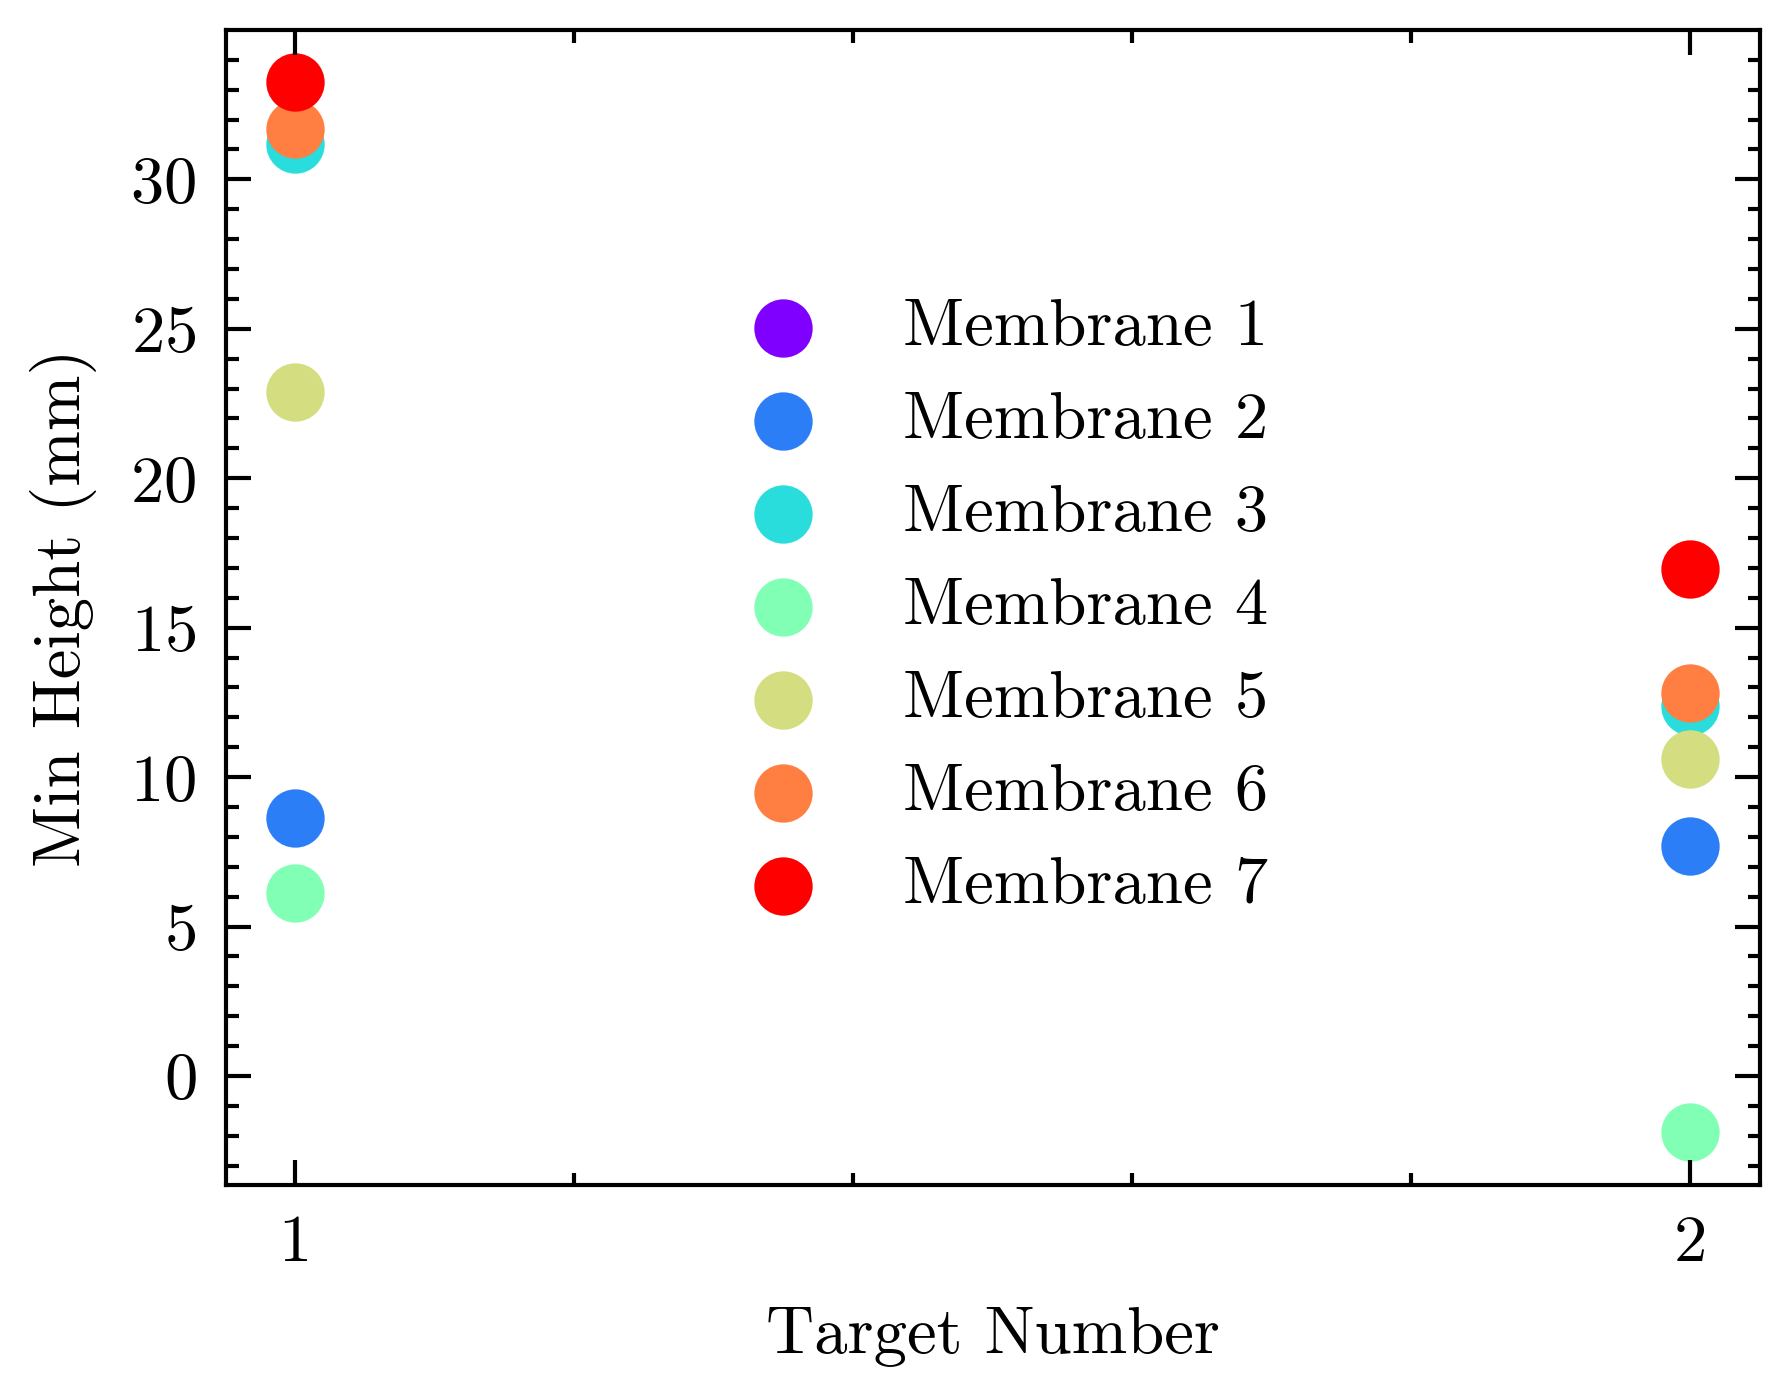

In [17]:
# def softmin
def softmin(x, axis = 0, hmax = 80):
    height_factor = (x/hmax) # shape (num_targets,)
    scale = hmax/15 # scalar for scaling logsumexp (a smooth way of computing minimum)
    height_factor = -nn.activation.logsumexp(-height_factor*scale)/scale # scalar
    return height_factor*hmax

# plot membranes performance
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    color = cm.rainbow(jnp.linspace(0, 1, len(mem_performance)))

    for i in range(len(mem_performance)):
        # set nans to 0
        # Sum (mean) score:
        # score1 = jnp.sum(jnp.nan_to_num(mem_performance[i][0]))
        # score2 = jnp.sum(jnp.nan_to_num(mem_performance[i][1]))
        # Min score:
        print(f'Membrane {i+1}: {mem_performance[i][0]}, {mem_performance[i][1]}')
        score1 = softmin(mem_performance[i][0])
        score2 = softmin(mem_performance[i][1])
        print(f'Membrane {i+1}: {score1}, {score2}')
        # plt.scatter(1, score1, c = color[i], label = f'{In_mem[i]}')
        plt.scatter(1, score1, c = color[i], label = f'Membrane {i+1}')
        plt.scatter(2, score2, c = color[i])

    plt.xlabel('Target Number')
    plt.ylabel('Min Height (mm)')
    plt.legend(loc = 'center')
    # xticks only every int
    plt.xticks([1,2], ['1','2'])
    plt.show()

## Target Points

In [18]:
def plot_target_and_planes(target_hs, target_ps, target_F, flat_h, flat_p, flat_F, min_index, set_lim = [], save_spin = False, add_ill_fit = False, save_file = ''):
    target_F = [i for i in target_F]
    target_ps = target_ps* PSI_to_Pa
    

    # # NOTE - still trying to get this to work for figure sizes (1/23)
    # fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
    # inches_per_pt = 1.0/72.27               # Convert pt to inches
    # golden_mean = (jnp.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    # # fig_width = fig_width_pt*inches_per_pt  # width in inches
    # fig_width = 3.5 #https://journals.ieeeauthorcenter.ieee.org/create-your-ieee-journal-article/create-graphics-for-your-article/resolution-and-size/#:~:text=Most%20charts%2C%20graphs%2C%20and%20tables,182%20millimeters%2C%20or%2043%20picas
    # fig_height =fig_width*golden_mean       # height in inches
    # plt.rcParams.update({
    #     'font.size': 10,
    #     'axes.labelsize': 10,
    #     'legend.fontsize': 10,
    #     'xtick.labelsize': 8,
    #     'ytick.labelsize': 8,
    # })
    # # plot the return p-h-F values and the plane from the model
    # fig = plt.figure(figsize=(2*fig_width,2*fig_height))
    # fig2 = plt.figure(figsize=(2*fig_width,2*fig_height))
    # fig = plt.figure(figsize=(fig_width,fig_height))
    # fig2 = plt.figure(figsize=(fig_width,fig_height))
    
    fig = plt.figure()
    fig2 = plt.figure()
    
    # fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(111, projection='3d')
    ax2 = fig2.add_subplot(111, projection='3d')
    
    points_per_mass = int(len(target_hs)/len(target_F))

    # plot the points of the target trajectories
    for i in range(len(target_hs)):

        colormap = cm.get_cmap('turbo', len(target_F))
        trajectory_index = int(i / points_per_mass)
        this_color = colormap(trajectory_index)
        if i % points_per_mass == 0:
            ax1.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index], color=this_color, alpha=1, label=f'Goal {trajectory_index}')
            ax2.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index], color=this_color, alpha=1, label=f'Goal {trajectory_index}') 
        else:
            # print(f'plotting target {i}')
            ax1.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index],alpha=1, color=this_color)
            ax2.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index],alpha=1, color=this_color)
    for min_indi in min_index:
        Fs = flat_F[min_indi]
        if len(Fs) > 0:
            ax1.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, label=f'Best-Match Model', color = 'gray')
            ax2.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, label=f'Best-Match Model', color = 'gray')

    # show some ill-fitting membranes
    if add_ill_fit:
        ill_errors = []
        for i in range(-5,0):
            Fs = flat_F[i]
            ax1.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, color = 'k')
            ax2.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, color = 'k')

    pad = -5
    ax1.set_ylabel('Pressure (kPa)', labelpad=pad)
    ax1.set_xlabel('Height (mm)', labelpad=pad)
    ax1.set_zlabel('Force (N)', labelpad=pad)
    ax2.set_ylabel('Pressure (kPa)', labelpad=pad)
    ax2.set_xlabel('Height (mm)', labelpad=pad)
    ax2.set_zlabel('Force (N)', labelpad=pad)
    ax1.tick_params(axis='x', pad=pad)
    ax1.tick_params(axis='y', pad=pad)
    ax1.tick_params(axis='z', pad=pad)
    ax2.tick_params(axis='x', pad=pad/2)
    ax2.tick_params(axis='y', pad=pad)
    ax2.tick_params(axis='z', pad=pad)
    ax1.legend()
    # set limits on z axis
    ax1.set_zlim(0 , max(target_F))
    ax2.set_zlim(0 , max(target_F))
    if len(set_lim) > 0:
        ax1.set_xlim(set_lim[0], set_lim[1])
        ax1.set_ylim(set_lim[2], set_lim[3])
        ax1.set_zlim(set_lim[4], set_lim[5])
        ax2.set_xlim(set_lim[0], set_lim[1])
        ax2.set_ylim(set_lim[2], set_lim[3])
        ax2.set_zlim(set_lim[4], set_lim[5])

        # # Define the formatter function
        # formatter = FuncFormatter(lambda x, pos: f'{x:.0f}')

        # # Apply the formatter to the x-axis
        # ax1.xaxis.set_major_formatter(formatter)
        # ax2.xaxis.set_major_formatter(formatter)

    ax1.view_init(0, 40)
    ax2.view_init(30, 10)
    ax2.legend()

    if save_spin:
        frames = plot_spin([ax1], save = True)
        imageio.mimsave('mem_{min_index}_compare.gif', frames, fps = 30, loop = 0)

    # fig.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust margins
    # fig2.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust margins

    # save the figure
    if len(save_file) > 0:
        fig.savefig(f'./{save_file}.png')
        fig2.savefig(f'./{save_file}_2.png')
    
    plt.tight_layout()
    plt.show()

In [19]:
os.getcwd()

'c:\\Users\\Greg\\Python\\Git_Local\\SPA_Design'

In [20]:
# 

C:\Users\Greg\AppData\Local\Temp\ipykernel_27748\3726371406.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('turbo', len(target_F))


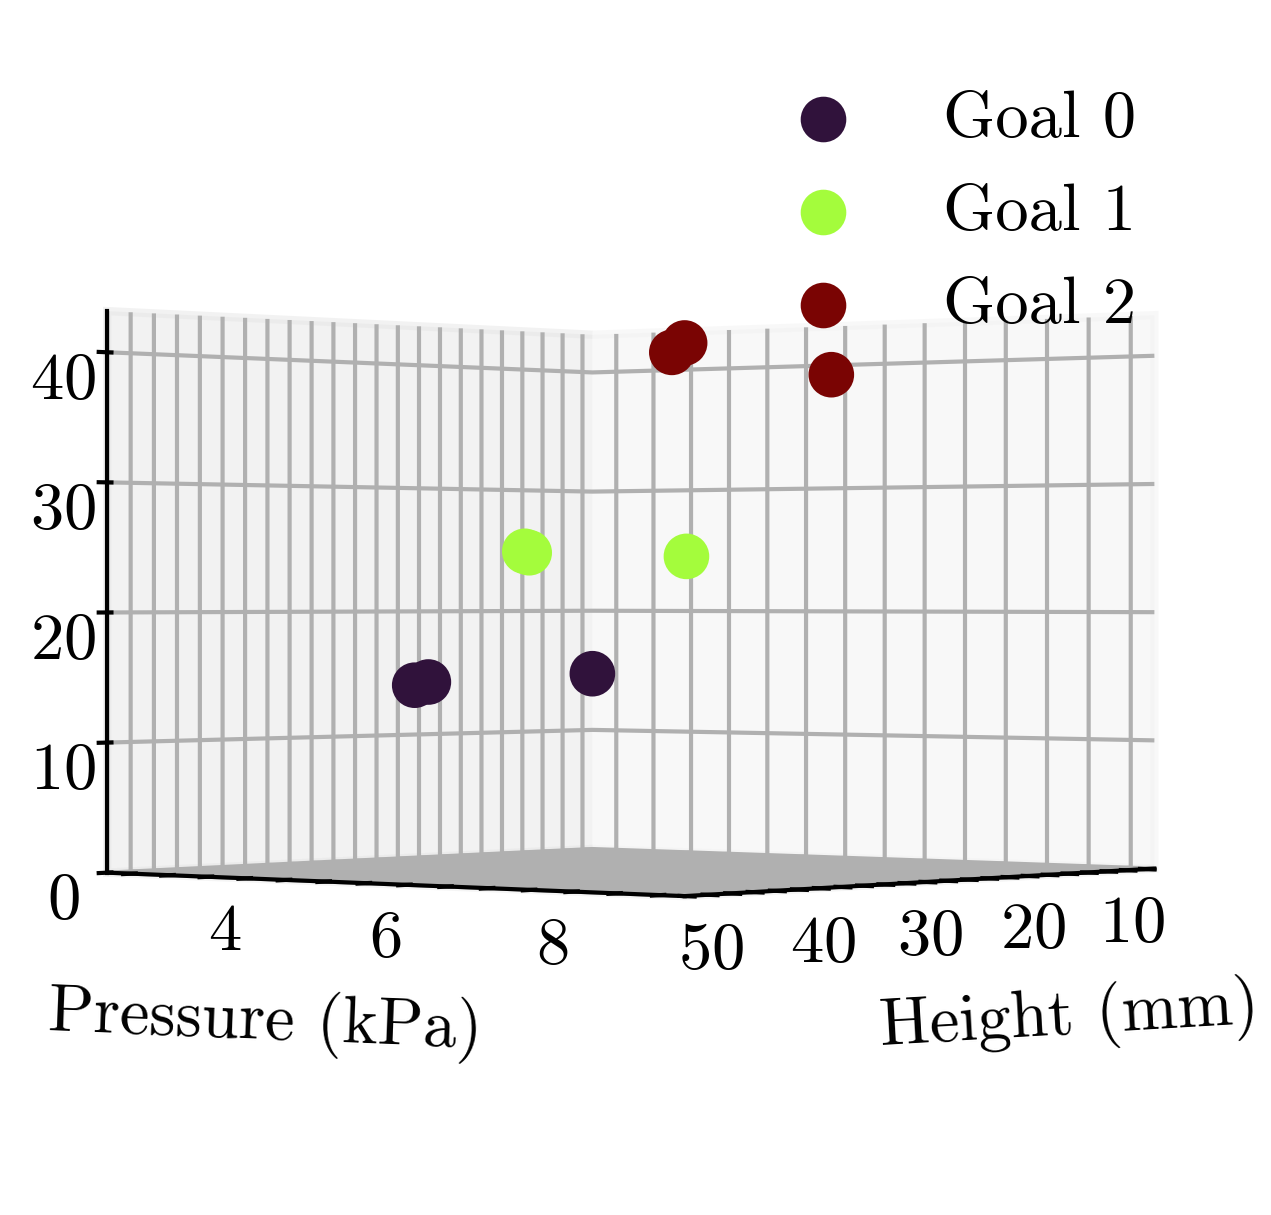

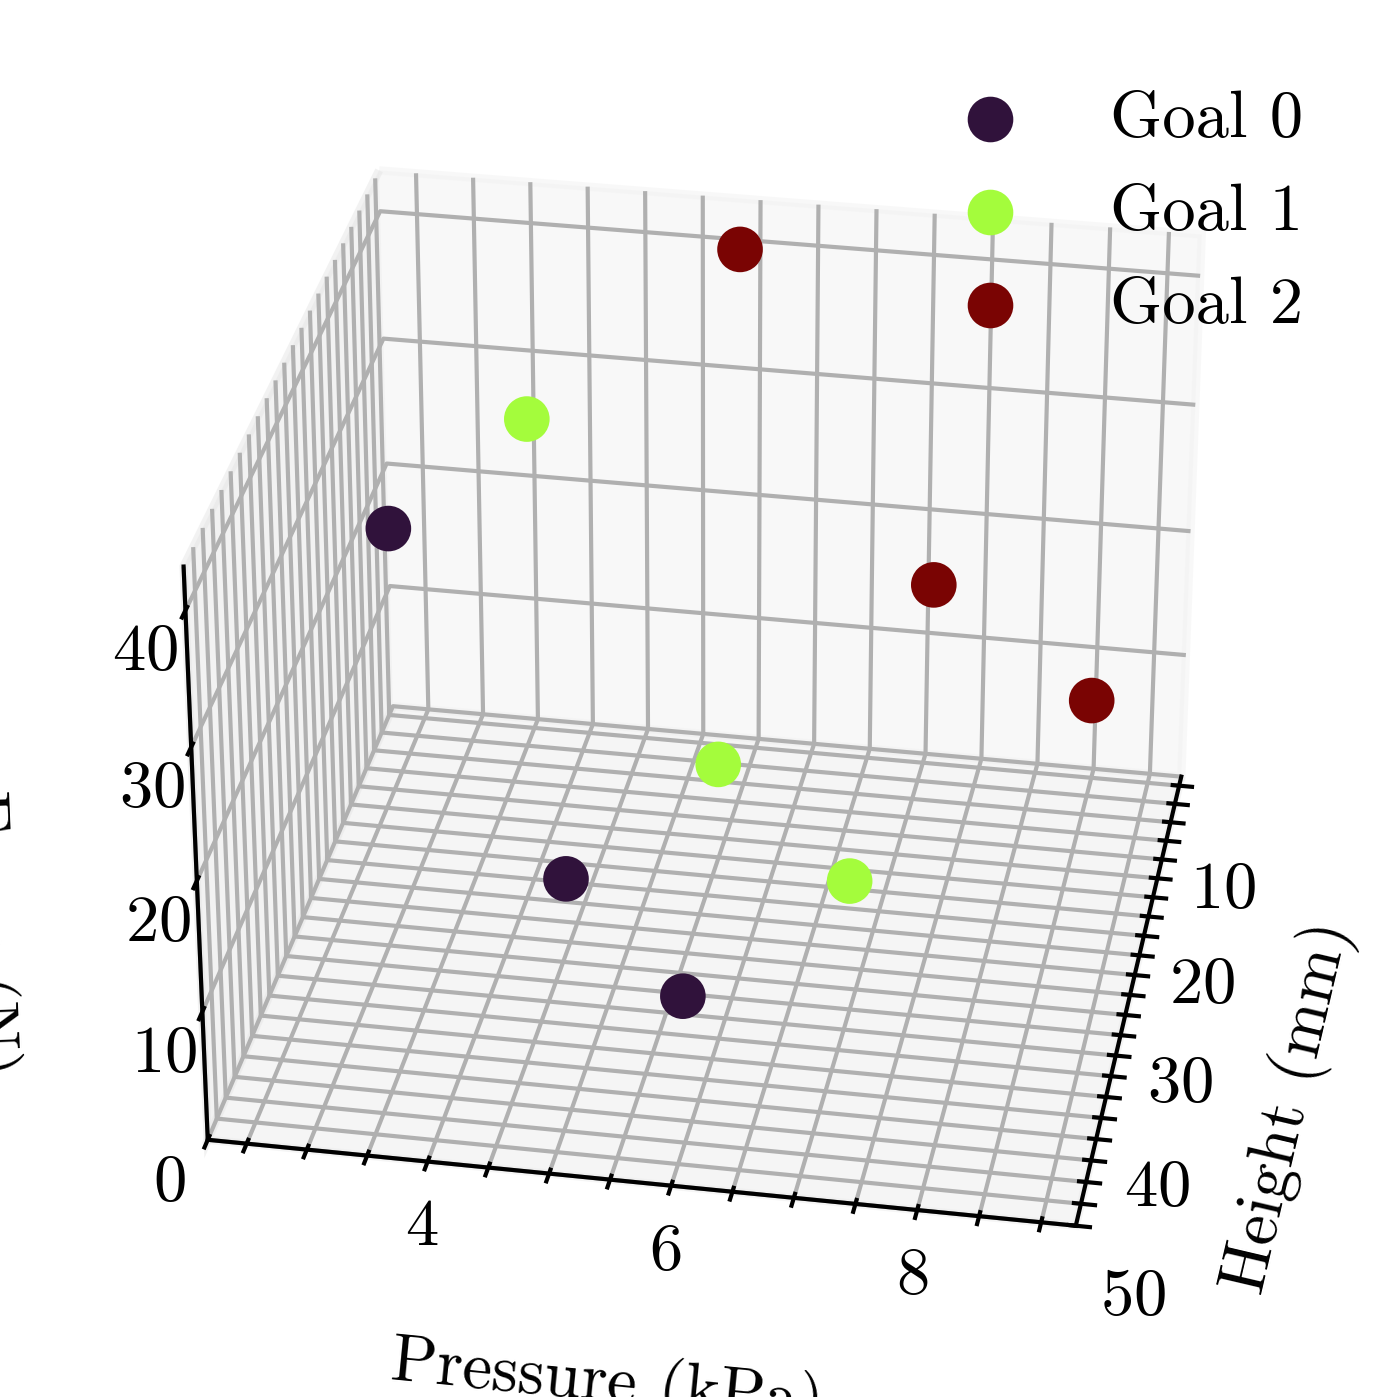

NameError: name 'flat_heights' is not defined

In [21]:
# import target points
Membrane_3_PSI = jnp.array( [[0.3156 ,0.7035, 0.8847],
 [0.4988 ,0.8856 ,1.0768],
 [0.7721 ,1.1348 ,1.3457]]) #PSI
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences - mm
test_F = [14.715, 24.525, 39.24] # N

ulim_z = 1.1*jnp.max(jnp.array(test_F))
ulim_x = jnp.max(test_h)
ulim_y = jnp.max(Membrane_3_PSI)*PSI_to_Pa/1000
llim_x = jnp.min(test_h)
llim_y = jnp.min(Membrane_3_PSI)*PSI_to_Pa/1000

lims= [llim_x, ulim_x, llim_y, ulim_y, 0, ulim_z]

with plt.style.context(['science','ieee','no-latex']):
    plot_target_and_planes(test_h, Membrane_3_PSI, test_F, [], [], [[]], [0], save_spin=False, set_lim = lims, save_file = 'Targets_Only')
    # # 2. Plot of the plane with the target points
    plot_target_and_planes(test_h, Membrane_3_PSI, test_F, flat_heights, flat_pressures, flat_F_matrices, [targ_mem_ids[i]],  set_lim = lims, save_spin=False, save_file = 'Plane_and_Targets')
    # 3. Plot of the actual lift trajectory with the points (top-down view, iso-view)
    compare_results(lift_df[i], membranes, targ_mem_ids[i], flat_heights, flat_pressures, flat_F_matrices, save_spin=False, set_lim = lims, save_file='Trajectories')


In [22]:
# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

In total there are 22 distinct membranes.


In [24]:
# Define Model
train_data = all_data
identity = lambda x : x
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [25]:
# train model
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))
# initialize model
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model

Initializing model...


In [27]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [17:10<00:00,  9.70it/s, loss=1.8127942, grad_norm=0.34584272]


In [ ]:
# dump model (params & train)
# model_name = 'feb25_model_params.pkl'
# pickle.dump(model.params, open(model_name, 'wb'))
# data_name = 'feb25_traindata.pkl'
# pickle.dump(train_data, open(data_name, 'wb'))

In [28]:
def apply_model(membranes, mem_index, h, p, model):
    # takes in a membrane index and applies the model to the membrane configuration
    # returns the force matrix for the membrane configuration (based on set height and pressure ranges)
        # can get away with a minimal height range due to the nature of the target trajectories
    h_len = len(h)
    p_len = len(p)
    # Ensure membrane is a (h_len,6) matrix
    membrane_matrix = jnp.tile(membranes[mem_index], (h.shape[0], 1))
    # Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
    u = jnp.hstack((h, membrane_matrix))
    # u = jnp.array((h.squeeze(),[membrane[0]]*h_len, [membrane[1]]*h_len, [membrane[2]]*h_len, [membrane[3]]*h_len, [membrane[4]]*h_len, [membrane[5]]*h_len)).T
    Fs = jnp.zeros((h_len, p_len)) #lbf
    
    # TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
    for i in range(h_len):
        pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), p)
        pred = nn.relu(pred)
        Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
 
    return Fs

In [32]:
# use the model to predict the force for each membrane in the dataset
# Solve for viable F-p-h data from model for given parameters
num_test = 100

h_num = int(num_test)
p_num = int(num_test)

height_range = jnp.linspace(0, 70, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

flat_Fs = [] #N

for key in new_dict.keys():
    # if key != list(new_dict.keys())[0]:
    #     break
    # change key to a membrane input
    key = key[1:-1]
    mem_config = jnp.array([float(x) for x in key.split(', ')])
    # replace nan w/ jnp.nan
    mem_config = jnp.where(jnp.isnan(mem_config), jnp.nan, mem_config)
    print(f'Using membrane configuration: {mem_config}')

    F1s = apply_model([mem_config],0,height_range,pressures, model)
    F_model = F1s.flatten() # N
    flat_Fs.append(F_model)

# Repeat the pressures for each height by tiling
p_model = jnp.tile(pressures, h_num).flatten('F') # Pa

# Tile the heights for each pressure
h_model = jnp.repeat(height_range, len(pressures)) #mm


Using membrane configuration: [ 1.  25.4  nan  nan  nan  nan]
Using membrane configuration: [ 1.  38.1  nan  nan  nan  nan]
Using membrane configuration: [ 1.5 25.4  nan  nan  nan  nan]
Using membrane configuration: [ 1.5 38.1  nan  nan  nan  nan]
Using membrane configuration: [ 2.  25.4  nan  nan  nan  nan]
Using membrane configuration: [ 2.  38.1  nan  nan  nan  nan]
Using membrane configuration: [ 1.  25.4 41.2 12.8 62.   5. ]
Using membrane configuration: [ 3.  38.1 49.   5.  62.   5. ]
Using membrane configuration: [ 3.   25.4  34.73  6.33 55.53 11.47]
Using membrane configuration: [ 1.  25.4 33.4  5.  46.4  5. ]
Using membrane configuration: [ 1.   25.4  33.4   5.   57.05  9.95]
Using membrane configuration: [ 1.  25.4 49.   5.  62.   5. ]
Using membrane configuration: [ 1.  38.1 46.1  5.  59.1  5. ]
Using membrane configuration: [ 1.   25.4  37.69  9.29 58.49  8.51]
Using membrane configuration: [ 1.   25.4  36.06  7.66 51.72  5.  ]
Using membrane configuration: [ 1.   25.4  44.

In [35]:
print(f'lens: {len(flat_Fs[0])}, {len(p_model)}, {len(h_model)}')

lens: 10000, 10000, 10000


[1.5, 25.4, nan, nan, nan, nan]


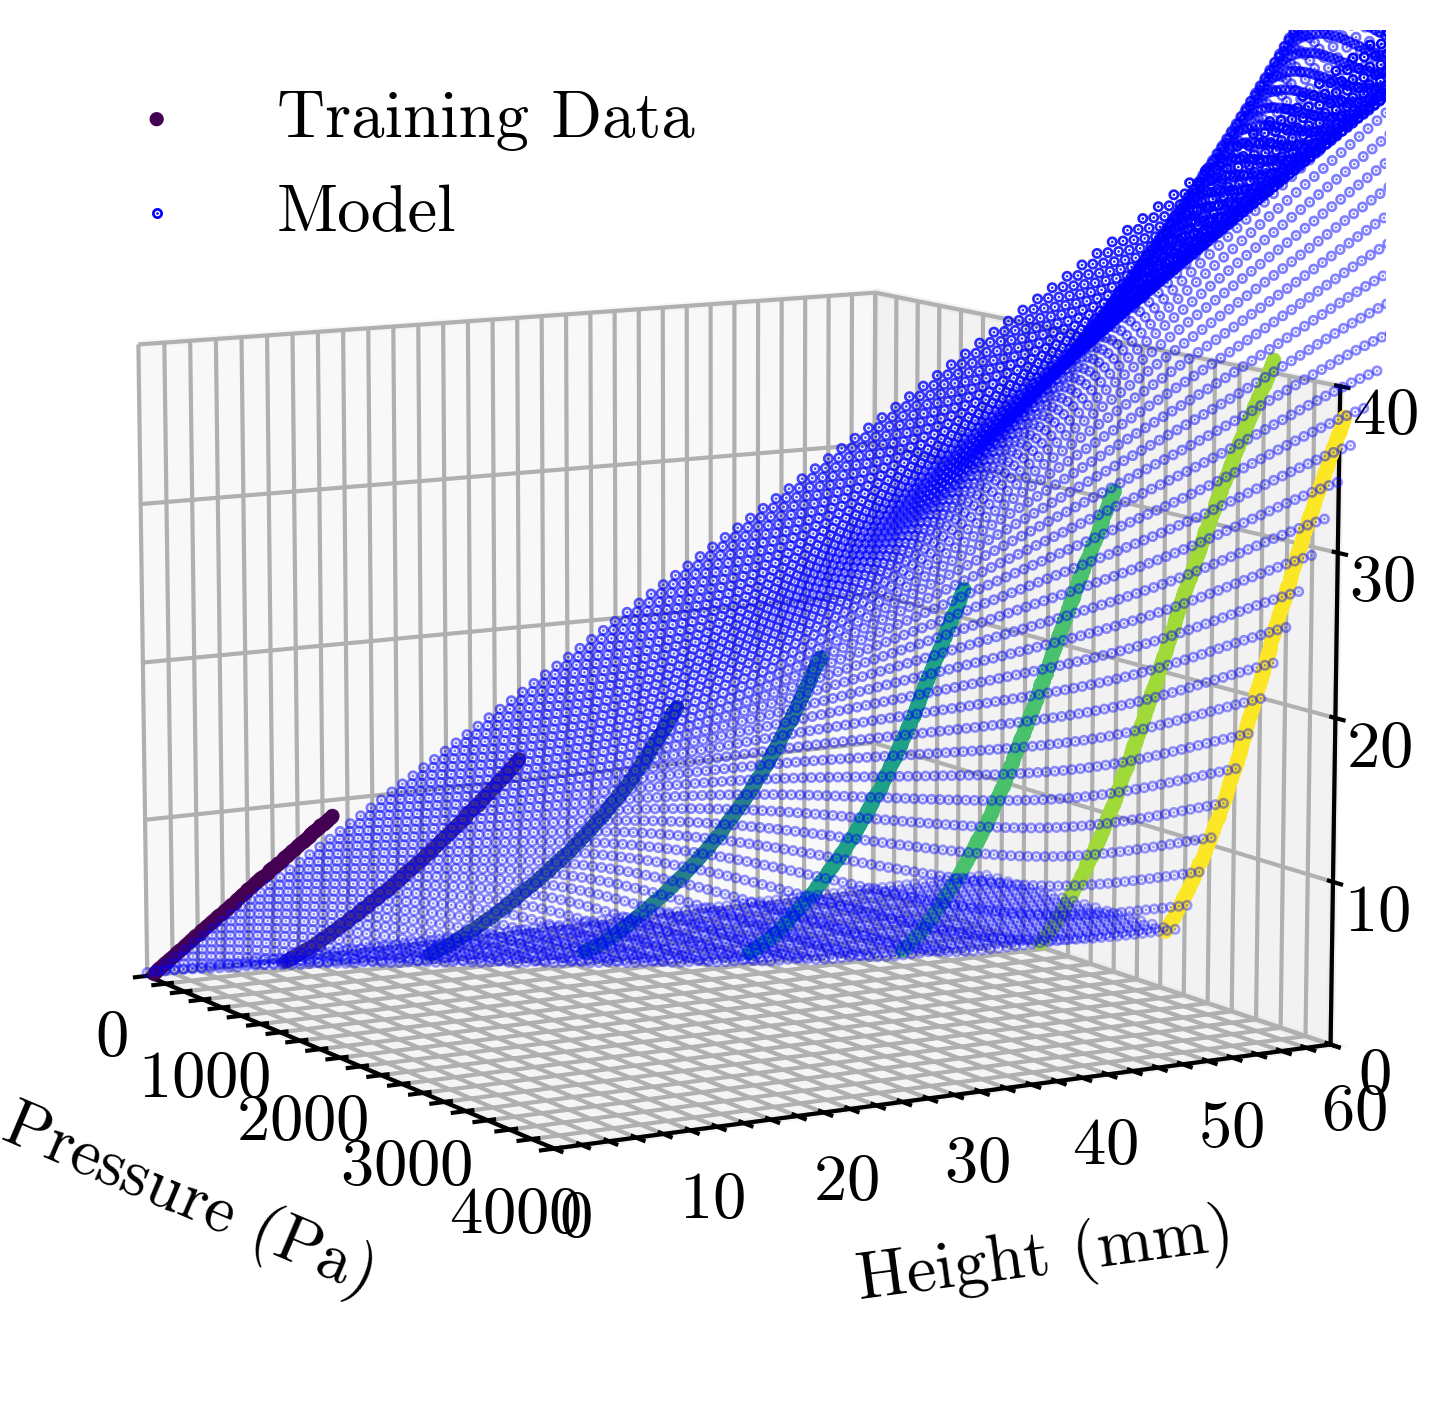

In [89]:
# choose a membrane to plot
i = 2
key = list(new_dict.keys())[i]
print(key)
subsample = 1

height = jnp.array([x[0] for x in new_dict[key][0][0]])
pressure = jnp.array([x[0] for x in new_dict[key][0][1]])
force = jnp.array([x[0] for x in new_dict[key][1]])

with plt.style.context(['science','ieee','no-latex']):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pressure, height, force, c=height, s=0.5,  marker='o') # TODO - what is going on?? python trying to square the lenth of all vectors.
    ax.scatter(p_model[::subsample], h_model[::subsample], flat_Fs[i][::subsample], s=0.1, c='b', marker='o')

    # change the view angle
    ax.view_init(elev=10, azim=-30)
    # set axis limits based on pressure, height, force
    ax.set_xlim([0, 4000])
    ax.set_ylim([0, 60])
    ax.set_zlim([0, 40])
    # tighten up to axis
    pad = -5
    ax.tick_params(axis='x', pad=pad+1)
    ax.tick_params(axis='y', pad=pad+1)
    ax.tick_params(axis='z', pad=pad)
    ax.set_xlabel('Pressure (Pa)', labelpad=pad)
    ax.set_ylabel('Height (mm)', labelpad=pad)
    ax.set_zlabel('Force (N)', labelpad=pad)
    plt.tight_layout()
    plt.legend(['Training Data', 'Model'], loc='upper left')
    plt.show()


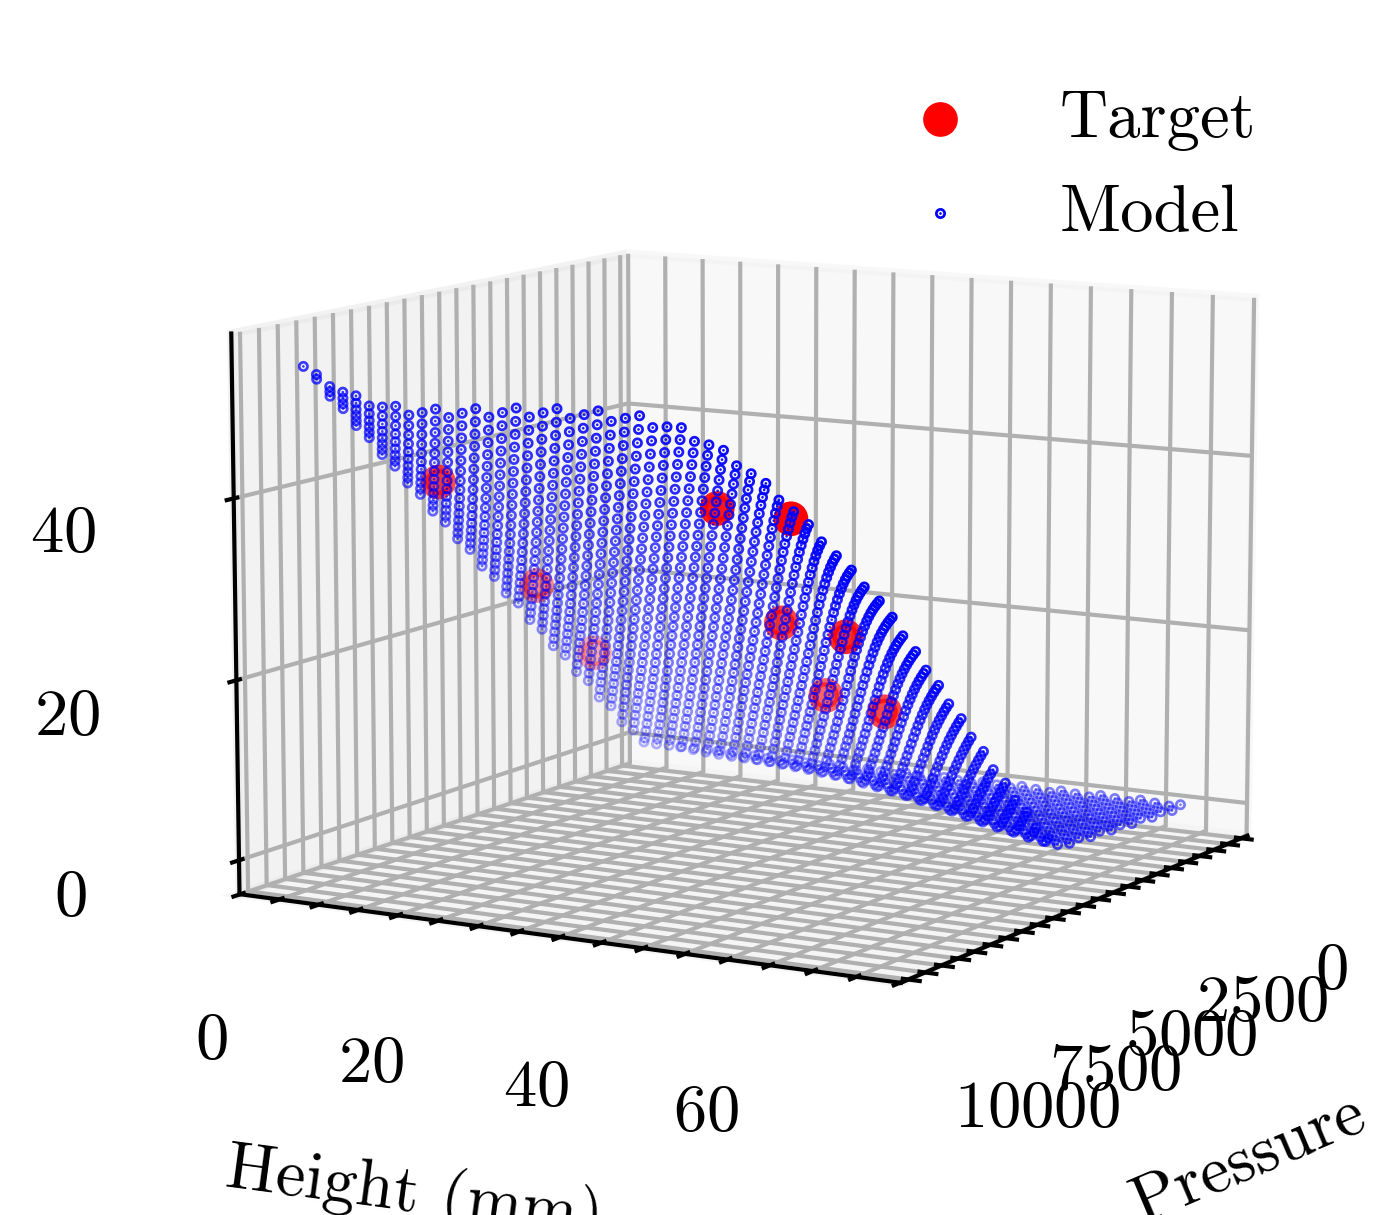

In [80]:
# choose some target points
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences
test_F = [14.715, 24.525, 39.24]
test_p = jnp.array([[0.3952, 0.5817, 0.6834],  [0.6478, 0.7839, 0.8618],  [1.0586, 1.0654, 1.1054]])*PSI_to_Pa

# flatten the test points
test_h_flat = test_h.flatten()
test_F_flat = jnp.array([jnp.repeat(f, 3) for f in test_F]).flatten()
test_p_flat = jnp.array(test_p).flatten()

mem_deets = jnp.array([ 2.  , 25.4 , 49.  ,  5.  , 62.  ,  5.  ])

flat_out = []
# solve for the model predictions
F1s = apply_model([mem_deets],0,height_range,pressures, model)
flat_out = F1s.flatten() # N

subsample = 7

# plot the model predictions
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(test_p_flat, test_h_flat, test_F_flat, c='r', s=10, marker='o')
    ax.scatter(p_model[::subsample], h_model[::subsample], flat_out[::subsample], c='b', s = 0.1, marker='o')
    ax.set_xlabel('Pressure (Pa)')
    ax.set_ylabel('Height (mm)')
    ax.set_zlabel('Force (N)')
    plt.legend(['Target', 'Model'])
    # change the view angle
    ax.view_init(elev=10, azim=30)

    plt.show()



In [124]:
# make plots with a std of values included

simple_h = jnp.linspace(0, 70, 8)[:,None] #mm

choice_mem = jnp.array([ 2.  , 25.4 , 49.  ,  5.  , 62.  ,  5.  ])


h_len = len(simple_h)
p_len = len(pressures)

print(f'len: {h_len}, {p_len}')
# Ensure membrane is a (h_len,6) matrix
membrane_matrix = jnp.tile(choice_mem, (simple_h.shape[0], 1))
# Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
u = jnp.hstack((simple_h, membrane_matrix))
Fs = jnp.zeros((h_len, p_len)) #lbf
low_Fs = jnp.zeros((h_len, p_len))
high_Fs = jnp.zeros((h_len, p_len))

# TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
for i in range(h_len):
    pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), pressures)
    pred = nn.relu(pred)
    Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
    low_Fs = low_Fs.at[i,:].set(pred.min(0).squeeze())
    high_Fs = high_Fs.at[i,:].set(pred.max(0).squeeze())

std_rdy_h = jnp.repeat(simple_h, len(pressures)) #mm
std_rdy_p = jnp.tile(pressures, h_len).flatten('F') # Pa
std_rdy_F = Fs.flatten() # N
std_rdy_low = low_Fs.flatten()
std_rdy_high = high_Fs.flatten()

print(f'lens: {len(std_rdy_F)}, {len(std_rdy_p)}, {len(std_rdy_h)}')

len: 8, 100
lens: 800, 800, 800


In [125]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable as sm

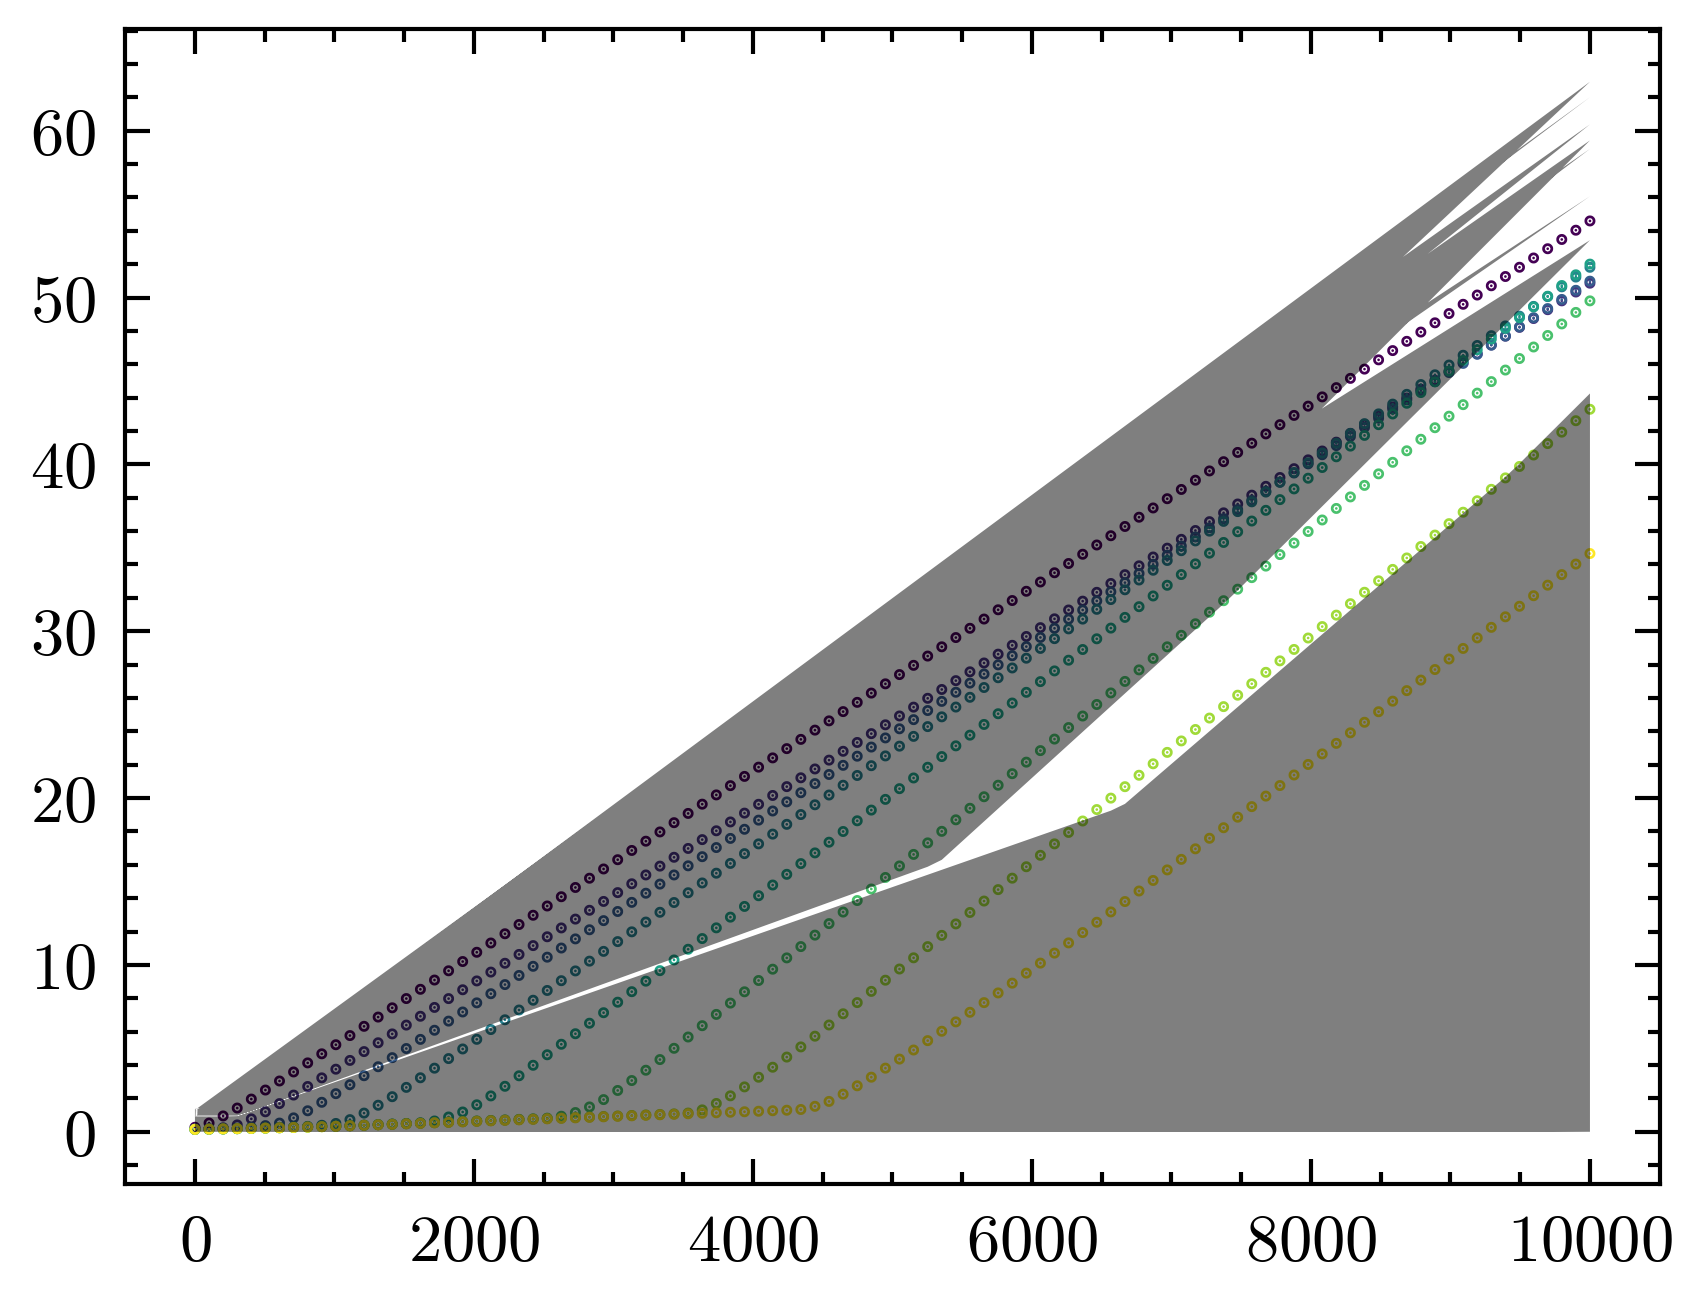

In [ ]:
# plot Fs, then add in the std as a shaded region using low_Fs and high_Fs
# TODO - this isn't working 2/15
# set up color
norm = Normalize(vmin=jnp.min(std_rdy_h), vmax=jnp.max(std_rdy_h))
cmap = plt.get_cmap('viridis')

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter(std_rdy_p, std_rdy_F, c=std_rdy_h, s=0.1, marker='o')
    plt.fill_between(std_rdy_p, std_rdy_low, std_rdy_high, alpha=0.5)
    plt.show()
